# Predicting behavior from ensembles

Can we predict behavior from ensemble activity in V1?

In [2]:
import sys
sys.path.insert(1, '/home/maria/Documents/EnsemblePursuit')
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt

In [3]:
data_path='/home/maria/Documents/LargeData/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)
#Uncomment to compute U and V
#ep=EnsemblePursuit(n_components=200,lam=0.01,n_kmeans=200)
#model=ep.fit(S.T[:10000,:])
#V=model.components_
#U=model.weights

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)


In [4]:
#Precomputed
V=np.load('/home/maria/Documents/kesa-et-al-2019/Pipelines/V.npy')
U=np.load('/home/maria/Documents/kesa-et-al-2019/Pipelines/U.npy')

In [5]:
def train_test_split(NT):
    nsegs = 20
    nt=NT
    nlen  = nt/nsegs
    ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
    itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
    itrain = np.ones(nt, np.bool)
    itrain[itest] = 0
    return itrain, itest

proc = np.load(data_path+'cam1_TX39_2019_05_31_1_proc_resampled.npy', allow_pickle=True).item()
motSVD = proc['motSVD'][:,iframe+dt]
motSVD -= motSVD.mean(axis=1)[:,np.newaxis]
beh=motSVD[:,:10000]
beh=zscore(beh,axis=1)
#Take the first 10000 timepoints for memory reasons
NT = motSVD[:,:10000].shape[1]
itrain,itest=train_test_split(NT)
covM = np.matmul(V.T[:,itrain], V.T[:,itrain].T)
lam = 1e5 # regularizer
covM += lam*np.eye(V.T.shape[0])
m=np.matmul(V.T[:,itrain], beh[:,itrain].T)
A = np.linalg.solve(covM, np.matmul(V.T[:,itrain], beh[:,itrain].T))
behPred = np.matmul(A.T, V.T[:,itest])

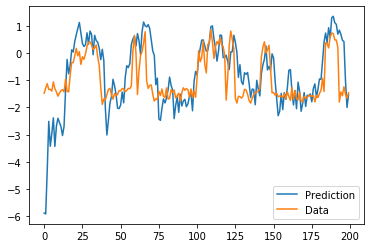

In [10]:
behP=zscore(behPred,axis=1)
beh_test=beh[:,itest]
plt.plot(behP[0,:200],label='Prediction')
plt.plot(beh_test[0,:200],label='Data')
plt.legend()

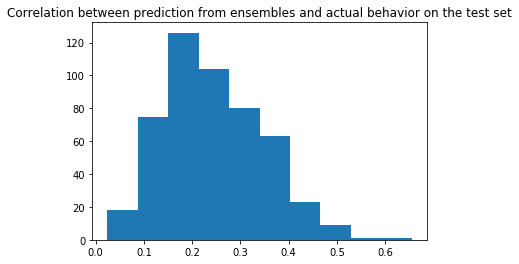

In [9]:
#Compute correlation between prediction and behavior for all behavior dimensions
corr_lst=[]
for j in range(0,500):
    corr_lst.append(np.corrcoef(behPred[j,:],beh[j,itest])[0,1])

plt.hist(corr_lst)
plt.title('Correlation between prediction from ensembles and actual behavior on the test set')
plt.show()